In [155]:
import os
os.environ["MKL_THREADING_LAYER"] = "GNU"
import exoplanet as xo

xo.utils.docs_setup()
print(f"exoplanet.__version__ = '{xo.__version__}'")

exoplanet.__version__ = '0.6.0'


In [156]:
import numpy as np
import lightkurve as lk
import matplotlib.pyplot as plt
import astropy.units as u
import pymc as pm
import pymc_ext.utils as pmx_u
import pymc_ext as pmx
from celerite2.pymc import terms, GaussianProcess


In [157]:
#20s cadence
tess_lc = lk.read('/Users/mschochet/Desktop/MSU_PHD/tess2025206162959-s0095-0000000441420236-0292-a_fast-lc.fits')

#120s cadence
tess_lc2 = lk.read('/Users/mschochet/Downloads/MAST_2025-12-24T1843 2/TESS/tess2025206162959-s0095-0000000441418475-0292-s/tess2025206162959-s0095-0000000441418475-0292-s_lc.fits')

In [163]:
tess_lc120s = tess_lc2.PDCSAP_FLUX.remove_outliers().normalize()
tess_lc20s = tess_lc.PDCSAP_FLUX.remove_outliers().normalize()


/var/folders/s0/h_46lpt56ll2ptpy3684xkym0000gn/T/ipykernel_17998/1018811518.py:1: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  tess_lc120s = tess_lc2.PDCSAP_FLUX.remove_outliers().normalize()
/var/folders/s0/h_46lpt56ll2ptpy3684xkym0000gn/T/ipykernel_17998/1018811518.py:2: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  tess_lc20s = tess_lc.PDCSAP_FLUX.remove_outliers().normalize()


<Axes: xlabel='Phase [JD]', ylabel='Normalized Flux'>

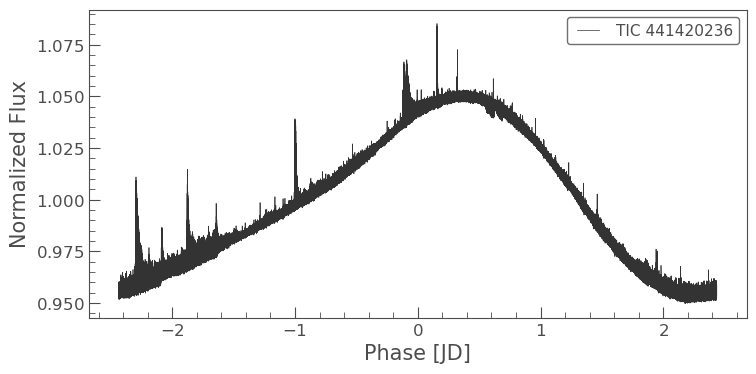

In [164]:
tess_lc20s.fold(period=4.869).plot()

Text(0.5, 1.0, '20s cadence')

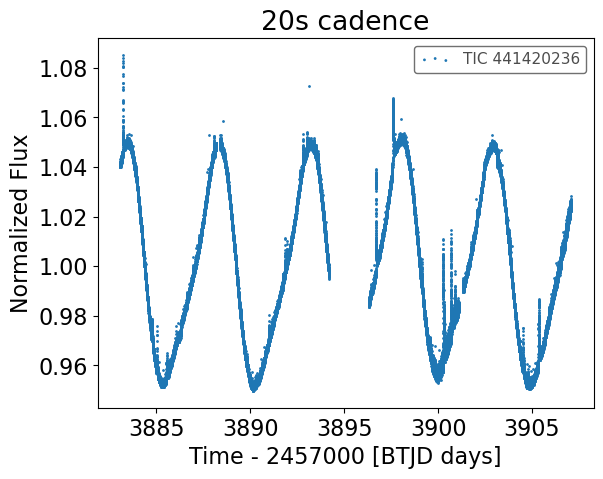

In [165]:
%matplotlib inline
fig, ax = plt.subplots()

tess_lc20s.scatter(ax=ax)
ax.set_title("20s cadence")

Text(0.5, 1.0, '120s cadence')

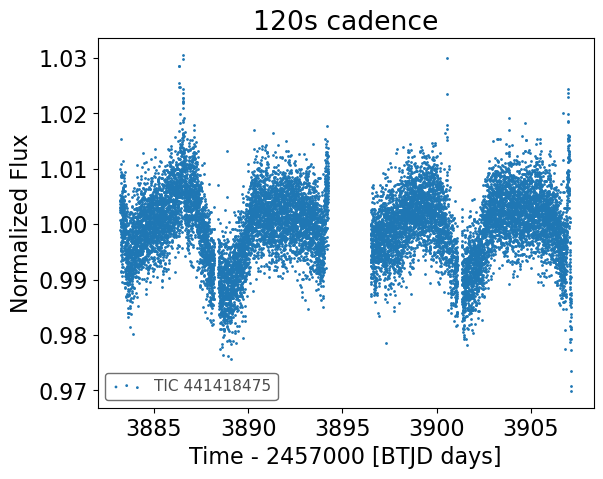

In [166]:
%matplotlib inline
fig, ax = plt.subplots()

tess_lc120s.scatter(ax=ax, title='120s cadence')

ax.set_title("120s cadence")

In [167]:
gp = lk.LightCurve.read("binned_lcs/gp.csv")
ip = lk.LightCurve.read("binned_lcs/ip.csv")
rp = lk.LightCurve.read("binned_lcs/rp.csv")
U = lk.LightCurve.read("binned_lcs/U.csv")
B = lk.LightCurve.read("binned_lcs/B.csv")
V = lk.LightCurve.read("binned_lcs/V.csv")

# Using 20s cadence lets fit a gp to the variability

In [168]:
x = np.ascontiguousarray(tess_lc20s.time.value, dtype=np.float64)
y = np.ascontiguousarray(tess_lc20s.flux, dtype=np.float64)
yerr = np.ascontiguousarray(tess_lc20s.flux_err, dtype=np.float64)


In [169]:
results = xo.estimators.lomb_scargle_estimator(
    x, y, max_peaks=1, min_period=2, max_period=10, samples_per_peak=100
)
peak = results["peaks"][0]

print(f"{peak['period']:.3f} days")

4.869 days


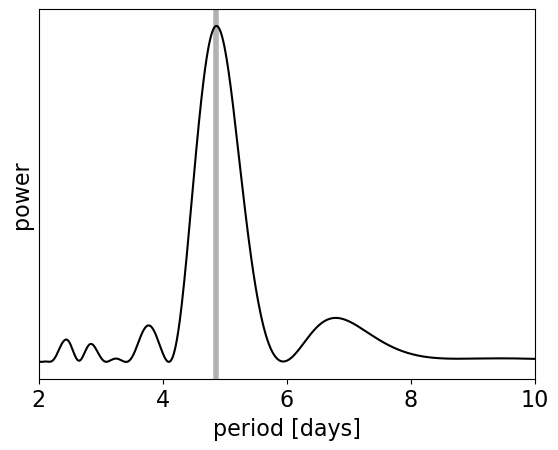

In [170]:
freq, power = results["periodogram"]
plt.plot(1 / freq, power, "k")
plt.axvline(peak["period"], color="k", lw=4, alpha=0.3)
plt.xlim((1 / freq).min(), (1 / freq).max())
plt.yticks([])
plt.xlabel("period [days]")
_ = plt.ylabel("power")

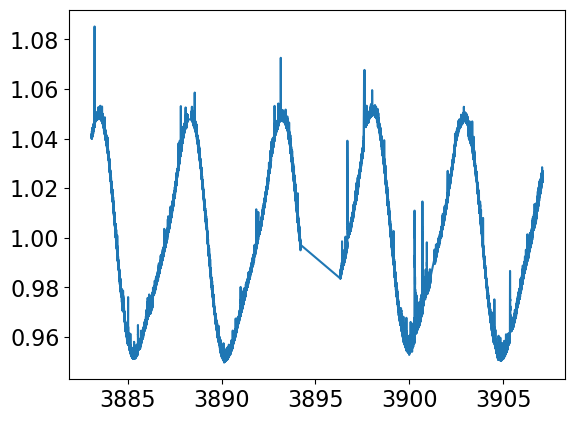

In [171]:
plt.plot(x, y)

In [172]:
import pytensor
pytensor.config.cxx = "/usr/bin/clang++"

In [184]:

with pm.Model() as model:
    # The mean flux of the time series
    mean = pm.Normal("mean", mu=1.0, sigma=0.08)

    # A jitter term describing excess white noise
    log_jitter = pm.Normal("log_jitter", mu=np.log(np.mean(yerr)), sigma=2.0)

    # A term to describe the non-periodic variability
    sigma = pm.InverseGamma(
        "sigma", **pmx_u.estimate_inverse_gamma_parameters(1.0, 5.0)
    )
    rho = pm.InverseGamma(
        "rho", **pmx_u.estimate_inverse_gamma_parameters(0.5, 2.0)
    )

    # The parameters of the RotationTerm kernel
    sigma_rot = pm.InverseGamma(
        "sigma_rot", **pmx_u.estimate_inverse_gamma_parameters(1.0, 5.0)
    )
    log_period = pm.Normal("log_period", mu=np.log(peak['period']), sigma=2.0)
    period = pm.Deterministic("period", log_period.exp())
    log_Q0 = pm.HalfNormal("log_Q0", sigma=2.0)
    log_dQ = pm.Normal("log_dQ", mu=0.0, sigma=2.0)
    f = pm.Uniform("f", lower=0.1, upper=1.0)

    # Set up the Gaussian Process model
    kernel = terms.SHOTerm(sigma=sigma, rho=rho, Q=1 / 3.0)
    kernel += terms.RotationTerm(
        sigma=sigma_rot,
        period=period,
        Q0=log_Q0.exp(),
        dQ=log_dQ.exp(),
        f=f,
    )
    gp = GaussianProcess(
        kernel,
        t=x,
        diag=yerr**2 + (2 * log_jitter).exp(),
        mean=mean,
        quiet=False,
    )

    # Compute the Gaussian Process likelihood and add it into the
    # the PyMC3 model as a "potential"
    gp.marginal("gp", observed=y)

    # Compute the mean model prediction for plotting purposes
    pm.Deterministic("pred", gp.predict(y))

    # Optimize to find the maximum a posteriori parameters
    map_soln = pmx.optimize(options={'disp':True})

/Users/mschochet/anaconda3/envs/exoplanet/lib/python3.11/site-packages/pytensor/tensor/random/op.py:97: FutureWarning: ndim_supp is deprecated. Provide signature instead.
  warnings.warn(
/Users/mschochet/anaconda3/envs/exoplanet/lib/python3.11/site-packages/pytensor/tensor/random/op.py:107: FutureWarning: ndims_params is deprecated. Provide signature instead.
  warnings.warn(


Output()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -4.98640D+05    |proj g|=  5.08631D+13


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9      1     21      1     0     0   5.086D+13  -4.986D+05
  F =  -498639.56033831049     

ABNORMAL_TERMINATION_IN_LNSRCH                              



 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


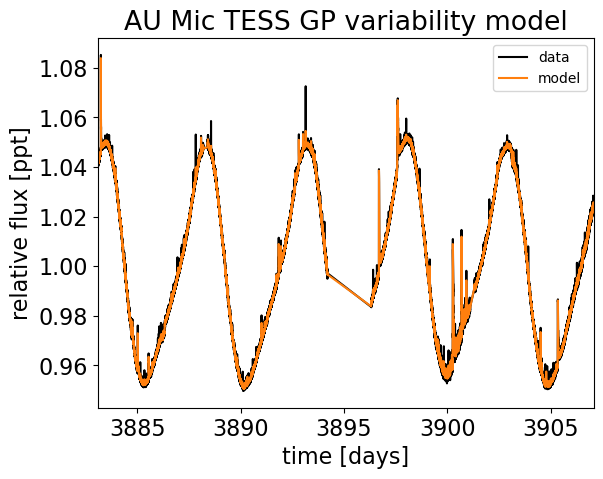

In [185]:
plt.plot(x, y, c='k', label="data")
plt.plot(x, map_soln["pred"], color="C1", label="model")
plt.xlim(x.min(), x.max())
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
_ = plt.title("AU Mic TESS GP variability model")